## Imports

In [20]:
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt

In [3]:
%autosave 180

Autosaving every 180 seconds


## Generate the dataset

In [4]:
df = pd.DataFrame(np.random.randint(0, 2, size=(30, 8)), columns=['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8'])
df['y'] = df.sum(axis=1)
df

,x1,x2,x3,x4,x5,x6,x7,x8,y
0,1,1,1,0,0,0,1,0,4
1,0,0,1,0,0,1,1,0,3
2,0,0,0,0,0,0,1,0,1
3,0,1,0,1,1,0,0,1,4
4,0,1,0,0,0,0,1,0,2
5,0,0,1,1,0,0,0,1,3
6,0,1,1,1,0,0,1,0,4
7,0,1,0,1,0,1,0,0,3
8,0,0,1,1,0,0,1,1,4
9,1,0,1,1,0,1,1,0,5


## Adder with the Elman Recurrent Neural Network

We'll build an Elman Recurrent Neural Network to predict the sum of 8 bits. We have one neuron that has two inputs : the input bit $x_{n}$ and the previous output $f_{t-1}$.

As we want to have a linear model, the activation function will be the identity, and we don't need a bias.

<img src="archi.png">

In [80]:
class RNNAdder():
    
    def __init__(self):
        # Our two weights initialized randomly between -1 and 1
        self.Vx = np.random.normal(1.0, 0.5)
        self.Vf = np.random.normal(1.0, 0.5)
        
        # Learning rates
        self.lr_x = 0.001
        self.lr_f = 0.001
        
        # Number of features
        self.T = 0
        
        # Neuron output matrix
        self.f = None
        
        # Error
        self.err = []
        
        # Historic of weights
        self.hist_Vx = [self.Vx]
        self.hist_Vf = [self.Vf]
        
        # Historic of gradients
        self.hist_dVx = []
        self.hist_dVf = []
    
    def forward(self, X):
        self.f = np.zeros((X.shape[0], X.shape[1] + 1))
        
        for t in range(self.T):
            self.f[:, t + 1] = self.Vf * self.f[:, t] + self.Vx * X[:, t]
        
        return self.f[:, -1]
    
    def compute_sse(self, y_hat, y):
        sse = 0.5 * np.sum(np.square(y_hat - y))
        return sse
    
    def compute_mae(self, y_hat, y):
        mae = np.sum(np.absolute(y_hat - y)) / y_hat.shape[0]
        return mae
    
    def backward(self, X, y, y_hat):
        dVx = 0
        dVf = 0
        
        for t in range(self.T):
            dVx += (np.sum((y_hat - y) * X[:, t]) * (self.Vf ** (self.T - t)))
            dVf += (np.sum((y_hat - y) * self.f[:, t - 1]) * (self.Vf ** (self.T - t)))
            
        self.Vx -= (self.lr_x * dVx)
        self.Vf -= (self.lr_f * dVf)
        
        self.hist_Vx.append(self.Vx)
        self.hist_Vf.append(self.Vf)
        
        self.hist_dVx.append(dVx)
        self.hist_dVf.append(dVf)
        
    def plot_hist(self):
        plt.plot([i for i in range(len(self.err))], self.err)
        plt.title('SSE')
        plt.show()
        plt.plot([i for i in range(len(self.hist_Vx))], self.hist_Vx)
        plt.plot([i for i in range(len(self.hist_Vf))], self.hist_Vf)
        plt.title('Weights')
        plt.show()
        plt.plot([i for i in range(len(self.hist_dVx))], self.hist_dVx)
        plt.plot([i for i in range(len(self.hist_dVf))], self.hist_dVf)
        plt.title('Gradients')
        plt.show()
    
    def fit(self, X, y, nb_epoch=50):
        self.T = X.shape[1]
        
        for k in range(nb_epoch):
            y_hat = self.forward(X)

            self.err.append(self.compute_sse(y_hat, y))

            self.backward(X, y, y_hat)
            
        self.plot_hist()
        
    def predict(self, X, y):
        # Compute prediction
        y_hat = self.forward(X)
        
        # Compute Mean Absolute Error
        mae = self.compute_mae(y_hat, y)
        
        # Print results
        for i in range(X.shape[0]):
            print('Seq:', X[i], '| y =', y[i], '| y_hat =', y_hat[i])
        print('MAE =', mae)

1.2075125788547465 1.3845275946675952


c:\users\maxim\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in multiply
c:\users\maxim\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in square
c:\users\maxim\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in double_scalars
c:\users\maxim\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: overflow encountered in multiply
c:\users\maxim\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: overflow encountered in double_scalars
c:\users\maxim\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in multiply
c:\users\maxim\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:52: Runti

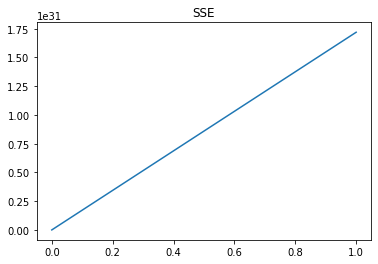

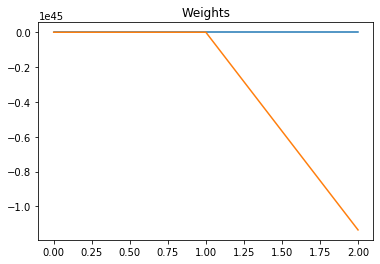

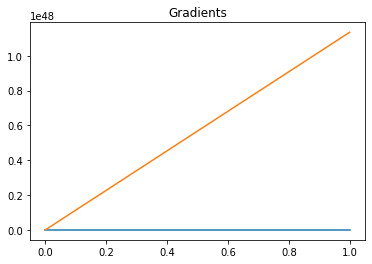

In [81]:
X, y = df.drop(columns='y').values, df['y'].values
train_X, test_X, train_y, test_y = X[:25], X[25:], y[:25], y[25:]


model = RNNAdder()
model.fit(train_X, train_y, nb_epoch=100)

In [73]:
model.predict(test_X, test_y)

Seq: [1 0 0 1 0 1 0 0] | y = 3 | y_hat = nan
Seq: [0 1 0 1 0 0 1 0] | y = 3 | y_hat = nan
Seq: [1 0 0 0 0 1 1 0] | y = 3 | y_hat = nan
Seq: [0 0 1 0 0 1 0 1] | y = 3 | y_hat = nan
Seq: [0 0 1 1 1 0 1 1] | y = 5 | y_hat = nan
MAE = nan


In [82]:
print(model.hist_Vf[:10])
print(model.hist_Vx[:10])

[1.3845275946675952, -116.0960094652268, -1.1346484990746286e+45, nan, nan, nan, nan, nan, nan, nan]
[1.2075125788547465, -6.908306682895894, -5.777882278424877e+29, nan, nan, nan, nan, nan, nan, nan]


In [83]:
print(model.hist_dVf[:10])
print(model.hist_dVx[:10])

[117480.53705989438, 1.1346484990746286e+48, nan, nan, nan, nan, nan, nan, nan, nan]
[8115.819261750641, 5.777882278424877e+32, nan, nan, nan, nan, nan, nan, nan, nan]


Looking at the gradients, we can observe the exploding gradients problem. To avoid it, let's try to implement two other backpropagation algorithm.
## Resilient backpropagation

In [95]:
class ResilientRNNAdder(RNNAdder):
    
    def __init__(self):
        RNNAdder.__init__(self)
        
        # Delta weights
        self.delta_x = 0.001
        self.delta_f = 0.001
        
        # Learning rate factors
        self.eta_p = 1.2
        self.eta_n = 0.5
        
    def find_lr_factor(self, grad, prev_grads):
        # If the list is empty (first iteration)
        if not prev_grads:
            return 1
        else:
            if grad * prev_grads[-1] > 0:
                return self.eta_p
            else:
                return self.eta_n
        
    def resilient_backward(self, X, y, y_hat):
        dVx = 0
        dVf = 0
        
        # Compute the same gradients
        for t in range(self.T):
            dVx += (np.sum((y_hat - y) * X[:, t]) * (self.Vf ** (self.T - t)))
            dVf += (np.sum((y_hat - y) * self.f[:, t - 1]) * (self.Vf ** (self.T - t)))
            
        # Update the deltas
        self.delta_x *= self.find_lr_factor(dVx, self.hist_dVx)
        self.delta_f *= self.find_lr_factor(dVf, self.hist_dVf)
        
        # Update the weights
        self.Vx -= (np.sign(dVx) * self.delta_x)
        self.Vf -= (np.sign(dVf) * self.delta_f)
        
        self.hist_Vx.append(self.Vx)
        self.hist_Vf.append(self.Vf)
        
        self.hist_dVx.append(dVx)
        self.hist_dVf.append(dVf)
        
    def fit(self, X, y, nb_epoch=50):
        self.T = X.shape[1]
        
        for k in range(nb_epoch):
            y_hat = self.forward(X)

            self.err.append(self.compute_sse(y_hat, y))

            self.resilient_backward(X, y, y_hat)
            
        self.plot_hist()

1.0059413728057114 0.2696028500945402


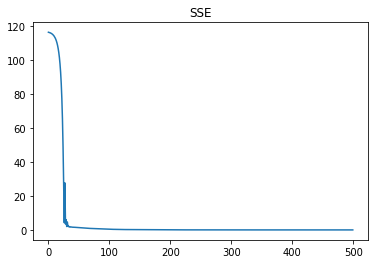

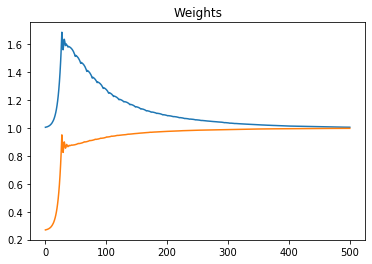

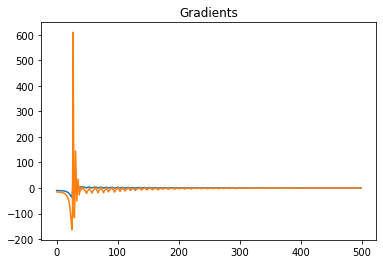

In [100]:
model = ResilientRNNAdder()
model.fit(train_X, train_y, nb_epoch=500)

In [101]:
print(model.hist_Vf[-30:])
print(model.hist_Vx[-30:])

[0.9978409453954652, 0.9978735155811, 0.9979125998038618, 0.997959500871176, 0.997936050337519, 0.9979477756043476, 0.9979618459245418, 0.9979787303087749, 0.9979989915698546, 0.9980233050831503, 0.9980524812991051, 0.9980874927582508, 0.9981295065092257, 0.9981084996337383, 0.998119003071482, 0.9981316071967745, 0.9981467321471255, 0.9981648820875466, 0.998186662016052, 0.9982127979302584, 0.9982441610273062, 0.9982284794787823, 0.9982363202530443, 0.9982457291821586, 0.9982570198970958, 0.9982705687550204, 0.99828682738453, 0.9983063377399415, 0.9983297501664352, 0.9983578450782278]
[1.0080734670054217, 1.0079952985598981, 1.0079014964252697, 1.0077889338637158, 1.0076538587898511, 1.0074917687012135, 1.0075728137455324, 1.007532291223373, 1.0074836641967817, 1.0074253117648722, 1.0073552888465807, 1.0072712613446309, 1.007170428342291, 1.0070494287394833, 1.006904229216114, 1.0069768289777987, 1.0069405290969564, 1.0068969692399456, 1.0068446974115328, 1.0067819712174373, 1.00670669

In [102]:
model.predict(test_X, test_y)

Seq: [1 0 0 1 0 1 0 0] | y = 3 | y_hat = 2.9971983139466354
Seq: [0 1 0 1 0 0 1 0] | y = 3 | y_hat = 3.000484062618909
Seq: [1 0 0 0 0 1 1 0] | y = 3 | y_hat = 3.0021390650108652
Seq: [0 0 1 0 0 1 0 1] | y = 3 | y_hat = 3.007066342461398
Seq: [0 0 1 1 1 0 1 1] | y = 5 | y_hat = 5.009575936611731
MAE = 0.004413418551253568
